In [2]:
# 최적화 라이브러리 scipy.optimize와 numpy를 임포트한다.
from scipy.optimize import minimize
import numpy as np

#  목적함수를 다음과 같이 정의한다.
def objective( x ):
  x1 = x[0]
  x2 = x[1]
  x3 = x[2]
  x4 = x[3]
  return x1 * x4 * ( x1 + x2 + x3 ) + x3

# constratint 함수는 제약조건 #1 x_1 * x_2 * x_3 * x_4 >= 25 이다.
def constraint1 ( x ):
    return x[0] * x[1] * x[2] * x[3] - 25

# constraint2 함수는 제약조건 #2 x_1^2 + x_2^2 + x_3^2 + x_4^2 = 40 이다.    
def constraint2 ( x ):
  sum_sq = np.sum( np.square( x ) )
  return sum_sq - 40

# 네 개 변수의 초깃값을 리스트로 지정한다.
x0 = [ 1, 5, 5, 1 ]

# 변수의 범위는 1~5로 튜플 형태다
b = ( 1, 5 )

# 범위를 나타내는 b를 원소로 갖는 bnds 변수 역시 튜플 형태이며 
# 앞서 살펴 본 한 개 변수 범위를 반복한다.
bnds = ( b,b,b,b )

# 제약식 두 개를 입력한다. 제약식 #1(위의 constraint1 함수)은 
# 네 개 변수의 곱이 25보다 크거나 같으므로 타입을 'ineq'로 정하고,
# 제약식 #2(위의 constraint2 함수)는 네 개 변수의 제곱이 40과 같으므로
# 타입을 'eq'로 정한다. 이어서 딕셔너리 형태로 만든 두 제약조건을 리스트로 묶는다.
con1 = { 'type':'ineq', 'fun':constraint1 }
con2 = { 'type':'eq', 'fun':constraint2 }
cons = [ con1, con2 ]

# 목적함수, 제약조건, 범위, 초깃값을 만들어 minimize 함수로 전달한다.
sol = minimize(objective, x0, method='SLSQP', bounds = bnds, constraints=cons )
print( sol )

     fun: 17.01401724556073
     jac: array([14.57227039,  1.37940764,  2.37940764,  9.56415081])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([1.        , 4.74299607, 3.82115466, 1.37940764])


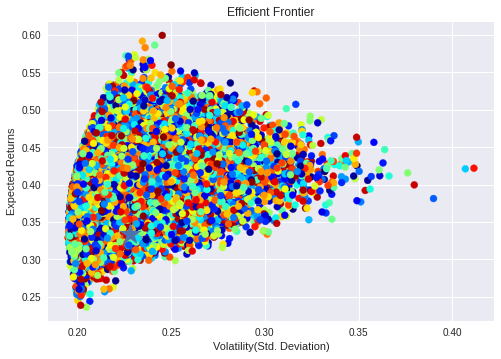

In [10]:
# 3장에서 구한 일간수익률 평균과 최적화로 얻은 투자 비중을 곱해 최소분산
# 포트폴리오의 기대수익률을 구한다.
import pandas as pd
from pandas_datareader import data as web
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib as mpl 

def obj_variance(weights, cov):
    return np.sqrt(weights.T @ covmat @ weights)

covmat=cov_daily*250
weights =np.array([0.2, 0.2, 0.2, 0.2, 0.2])
bnds = ((0,1), (0,1), (0,1), (0,1), (0,1))
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) 
res = minimize(obj_variance, weights,(covmat), method='SLSQP', bounds=bnds, constraints=cons)

tickers = ['AAPL', 'F', 'AMZN', 'GE', 'TSLA']
pxclose = pd.DataFrame()

for t in tickers:
    pxclose[t] = web.DataReader(t, data_source='yahoo',start='01-01-2019', end='31-12-2019')['Adj Close']

ret_daily = pxclose.pct_change()
ret_annual = ret_daily.mean() * 250
cov_daily = ret_daily.cov()
cov_annual = cov_daily * 250
rets = np.sum( ret_daily.mean() * res[ 'x' ]) * 250

# 최소분산포트폴리오의 위험을 구한다.
vol = np.sqrt( res [ 'x' ].T @ covmat @ res[ 'x' ])

# 차트에 표시하기 위해 np.array로 변환한다. p_volatility와 p_returns는
# 3장에서 n_ports만큼의 포트폴리오를 만들면서 저장한 수익률과 변동성이다.
p_returns = []
p_volatility = []
p_weights = []

n_assets = len(tickers)
n_ports = 30000

for s in range(n_ports):
  wgt = np.random.random(n_assets)
  wgt /= np.sum(wgt)
  ret = np.dot(wgt, ret_annual)
  vol = np.sqrt(np.dot(wgt.T, np.dot(cov_annual, wgt)))
  p_returns.append(ret)
  p_volatility.append(vol)
  p_weights.append(wgt)

p_volatility = np.array( p_volatility )
p_returns = np.array( p_returns )

# 변수 n_ports만큼 색상을 무작위로 얻어 o로 표시되는 
# 포트폴리오 색상을 지정한다.
colors = np.random.randint( 0, n_ports, n_ports )

# 분산형 차트를 그린다. 아래 코드 대부분은 3장에서 이미 사용한 것이며,
# plt.scatter( vol, rets, marker="*", s=500, alpha=1.0 )만 추가했다. 
# 실행 결과 최소분산포트폴리오의 수익률과 위험이 분산 차트로 표시된다.

plt.style.use( 'seaborn' )
plt.scatter( p_volatility, p_returns, c=colors, marker='o', cmap=mpl.cm.jet )
plt.scatter( vol, rets, marker="*", s=500, alpha=1.0 )
plt.xlabel( 'Volatility(Std. Deviation)' )
plt.ylabel( 'Expected Returns' )
plt.title( 'Efficient Frontier' )
plt.show( )
 

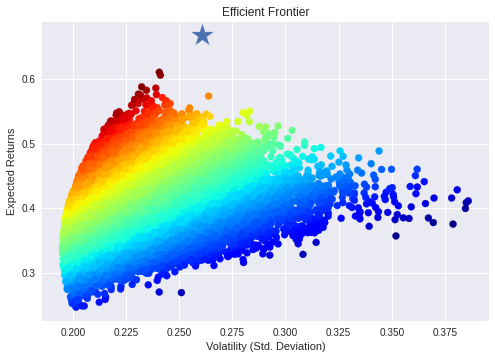

In [27]:
# 최적화 라이브러리를 임포트한다.
from scipy.optimize import minimize

# 목적함수를 선언한다.
def obj_sharpe( weights, returns, covmat, rf ):
    ret = np.dot( weights, returns )
    vol = np.sqrt( np.dot( weights.T, np.dot( covmat, weights ) ) )
    return 1 / (( ret-rf ) / np.sqrt(vol ) )

# 이전과 마찬가지로 종목 개수(n_asset)와 공분산을 준비한다.
n_assets = len( tickers )
covmat = cov_daily * 250    

#  무위험 수익률
rf = 0.01

# 초기 투자 비중은 종목 개수만큼 균등하게 정한다
weights = np.ones( [n_assets] )  / n_assets

# 투자 비중의 범위는 0~100%이고 이를 종목 개수만큼 튜플로 만든다.
bnds = tuple( (0., 1.) for i in range (n_assets) )

# 앞서 최적화 함수 constraint1(), constraint2()를 
# 정의해 제약식을 만든 방법과 같다.
# 제약식은 람다(lambda) 함수로 만든다.
cons = ( { 'type': 'eq', 'fun': lambda w:np.sum(w) - 1 } )

# minimize() 함수에 목적함수, 초기 투자 비중, 투자 비중을 제외한 목적함수에 전달할
# 나머지 매개 변수, 최적화 알고리즘, 범위, 제약조건을 전달한다.
res = minimize( obj_sharpe, weights, ( ret_annual, covmat, rf ), method = 'SLSQP', bounds=bnds, constraints=cons )

p_returns = []
p_volatility = []
p_weights = []

n_assets = len( tickers )
n_ports = 30000

for s in range( n_ports ):
  wgt = np.random.random( n_assets )
  wgt /= np.sum( wgt )
  ret = np.dot( wgt, ret_annual )
  vol = np.sqrt( np.dot( wgt.T, np.dot(cov_annual, wgt ) ) )
  p_returns.append( ret )
  p_volatility.append( vol )
  p_weights.append( wgt )

rets = np.sum( ret_daily.mean() * res[ 'x' ] ) * 250  
vol = np.sqrt( res[ 'x' ].T @ covmat @ res[ 'x' ])
p_volatility = np.array( p_volatility )
p_returns = np.array( p_returns )

colors = p_returns / p_volatility
plt.style.use( 'seaborn' )
plt.scatter( p_volatility, p_returns, c=colors, marker='o', cmap=mpl.cm.jet )
plt.scatter( vol, rets, marker="*", s=500, alpha=1.0 )
plt.xlabel( 'Volatility (Std. Deviation)' )
plt.ylabel( 'Expected Returns' )
plt.title( 'Efficient Frontier' )
plt.show()

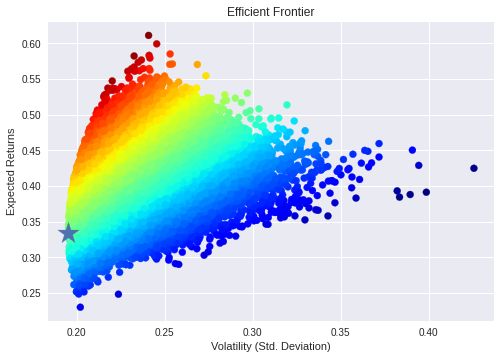

In [26]:
from scipy.optimize import minimize

def obj_variance(weights, cov):
    return np.sqrt(weights.T @ covmat @ weights)

covmat=cov_daily*250
weights =np.array([0.2, 0.2, 0.2, 0.2, 0.2])
bnds = ((0,1), (0,1), (0,1), (0,1), (0,1))
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) 
res = minimize(obj_variance, weights,(covmat), method='SLSQP', bounds=bnds, constraints=cons)

p_returns = []
p_volatility = []
p_weights = []

n_assets = len(tickers)
n_ports = 30000

for s in range(n_ports):
  wgt = np.random.random(n_assets)
  wgt /= np.sum(wgt)
  ret = np.dot(wgt, ret_annual)
  vol = np.sqrt(np.dot(wgt.T, np.dot(cov_annual, wgt)))
  p_returns.append(ret)
  p_volatility.append(vol)
  p_weights.append(wgt)

rets = np.sum(ret_daily.mean() * res['x']) * 250
vol = np.sqrt(res['x'].T @ covmat @ res['x'])
p_volatility = np.array(p_volatility)
p_returns = np.array(p_returns)
colors = p_returns/p_volatility
plt.style.use('seaborn')
plt.scatter(p_volatility, p_returns, c=colors, marker='o', cmap=mpl.cm.jet)
plt.scatter(vol, rets, marker="*", s=500, alpha=1.0)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()